In [9]:
# !pip install pyclustertend
# !pip install MulticoreTSNE
# !pip install catboost
# ! pip install shap

In [10]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyclustertend import hopkins
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from catboost import CatBoostClassifier, cv, Pool
import shap

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", font_scale=1.4)
data_path = '../data/'

In [11]:
df = pd.read_csv(data_path + 'dataset.csv')
label_df = df['is_outflow']
dataset_df = df.drop(['Unnamed: 0', 'is_outflow', 'client_id'], axis=1)

In [12]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   most_freq_plant_type      99995 non-null  object 
 1   diff_plants_amount        99995 non-null  int64  
 2   check_sum                 99995 non-null  float64
 3   promo_amount              99995 non-null  float64
 4   priv_lbl_amount           99995 non-null  float64
 5   alco_amount               99995 non-null  float64
 6   food_amount               99995 non-null  float64
 7   nonfood_amount            99995 non-null  float64
 8   return_sum                99995 non-null  float64
 9   gender                    99640 non-null  object 
 10  city                      99995 non-null  object 
 11  birthyear                 98219 non-null  float64
 12  days_since_last_purchase  99995 non-null  int64  
 13  purch_num                 99995 non-null  float64
 14  return

### Для сравнения моделей будем использовать метрику **ROC-AUC**

In [13]:
def one_hot_encode(df, categorial_feature):
    ohe = pd.get_dummies(df[categorial_feature],
                   prefix=categorial_feature,
                   dummy_na=df[categorial_feature].isna().any())
    return pd.concat([df.drop(categorial_feature, axis=1), ohe], axis=1)

categorial_features = ['most_freq_plant_type', 'gender', 'city']
for i in categorial_features:
    dataset_df = one_hot_encode(dataset_df, i)

Заполним пропущенные значения:

gender: в ohe NaN вынесен в отдельную категорию

birthyear: NaN -> mean

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset_df, label_df,
                                                    test_size=0.2, random_state=42, 
                                                    stratify=label_df)
X_train.loc[:, 'birthyear'] = X_train['birthyear'].fillna(X_train['birthyear'].mean())
X_test.loc[:, 'birthyear'] = X_test['birthyear'].fillna(X_test['birthyear'].mean())

In [15]:
sum(y_train == True)/len(y_train), sum(y_test == True)/len(y_test)

(0.268088404420221, 0.26806340317015853)

In [16]:
regression_ft = ['diff_plants_amount', 'check_sum', 'promo_amount',
       'priv_lbl_amount', 'alco_amount', 'food_amount', 'nonfood_amount',
       'return_sum', 'birthyear', 'days_since_last_purchase', 'purch_num',
       'return_num']

categorial_ft = X_train.columns.drop(regression_ft).tolist()

In [17]:
X_train.head()

,diff_plants_amount,check_sum,promo_amount,priv_lbl_amount,alco_amount,food_amount,nonfood_amount,return_sum,birthyear,days_since_last_purchase,purch_num,return_num,most_freq_plant_type_HM,most_freq_plant_type_SM,gender_F,gender_M,gender_nan,city_Moscow,city_Other,city_St. Petersburg
56985,1,2083.333333,6.500000,3.166667,1.166667,12.833333,4.833333,0.00,1990.0,94,0.666667,0.000000,1,0,1,0,0,0,1,0
93904,2,2691.571429,10.285714,3.000000,0.000000,12.571429,5.428571,0.00,1967.0,16,0.777778,0.000000,1,0,1,0,0,0,1,0
59353,2,5815.492131,25.163934,1.770492,0.573770,23.163934,5.852459,-5857.76,1981.0,6,6.777778,0.222222,1,0,0,1,0,0,1,0
30537,2,2127.900000,11.500000,2.600000,2.100000,10.800000,2.600000,0.00,1980.0,19,1.111111,0.000000,1,0,1,0,0,0,0,1
44791,2,1813.222222,11.740741,3.333333,1.148148,12.962963,4.629630,0.00,1978.0,22,3.000000,0.000000,1,0,1,0,0,0,1,0


### Посмотрим на данные

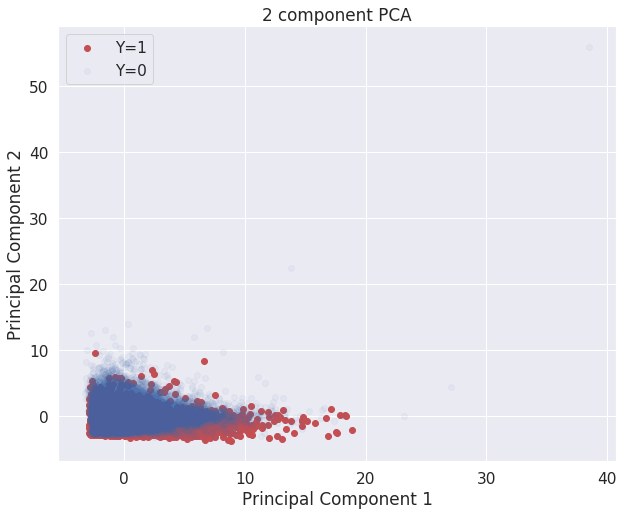

In [18]:
pca = PCA(random_state=42)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(X_train[regression_ft]))

plt.figure(figsize = (10, 8))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2 component PCA")

plt.scatter(principalComponents[y_train == 1, 0], 
            principalComponents[y_train == 1, 1],
            color="r",
            label="Y=1")

plt.scatter(principalComponents[y_train == 0, 0], 
            principalComponents[y_train == 0, 1],
            color="b",
            label="Y=0",
            alpha=0.05)

plt.legend()
plt.show()

In [12]:
tsne = TSNE(random_state=42, n_jobs=-1, verbose=1)

In [11]:
%%time
tsne_components = tsne.fit_transform(X_train[regression_ft])

NameError: name 'tsne' is not defined

In [ ]:
np.savetxt(data_path + 'tsne_data.csv', tsne_components, delimiter=',')

In [13]:
# uncomment to load tSNE data
tsne_components = np.loadtxt(data_path + 'tsne_data.csv', delimiter=',')

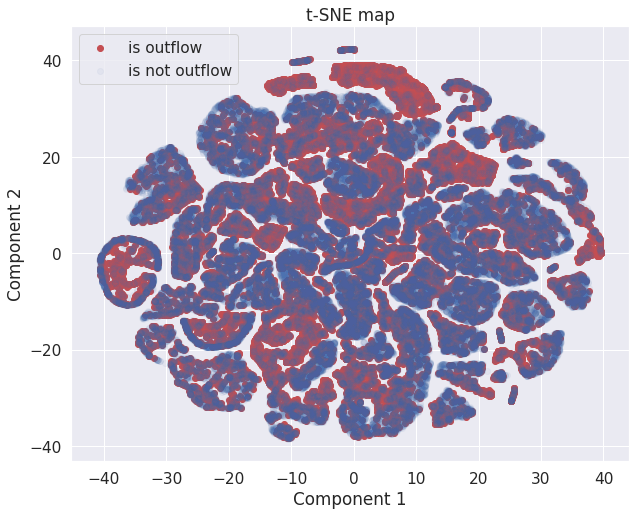

In [14]:
plt.figure(figsize = (10, 8))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE map')

plt.scatter(tsne_components[y_train == True, 0],
            tsne_components[y_train == True, 1],
            color='r',
            label='is outflow')

plt.scatter(tsne_components[y_train == False, 0],
            tsne_components[y_train == False, 1],
            color='b',
            label='is not outflow', 
            alpha=0.05)

plt.legend()
plt.show()

### Clustering 

### Проверим данные на наличие кластерной структуры

статистика Хопкинса:
$$
H={\frac {\sum _{i=1}^{m}{u_{i}}}{\sum _{i=1}^{m}{u_{i}}+\sum _{i=1}^{m}{w_{i}}}}
$$

должна быть близка к нулю

In [16]:
hopkins(X_train[regression_ft], 10000)

0.0003924021103341206

#### KMeans

Найдем оптимальное число классов используя метод локтя и метрику силуэт

коэффициент силуэта:

$$
s = \frac{b-a}{max(a,b)}
$$

где b - среднее расстояние от данного объекта до объектов из ближайшего другого кластера, a - среднее расстояние
от данного объекта до объектов из ближайшего другого кластера

In [ ]:
%%time
sse = []
silhouette = []
for k in range(2, 10):
    clear_output()
    print('iteration: ', k)
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42, n_jobs=-1)
    labels = kmeans.fit_predict(X_train[regression_ft])
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_train[regression_ft], labels, random_state=42))

iteration:  9
CPU times: user 15min 44s, sys: 6min, total: 21min 44s
Wall time: 10min 16s


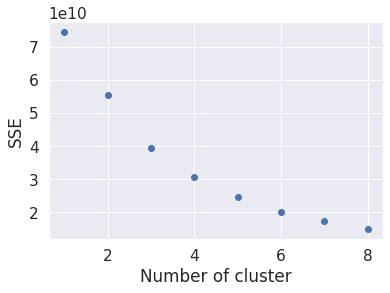

In [ ]:
plt.scatter(range(1, len(sse)+1), sse)
plt.xlabel('Number of cluster')
plt.ylabel('SSE')

plt.show()

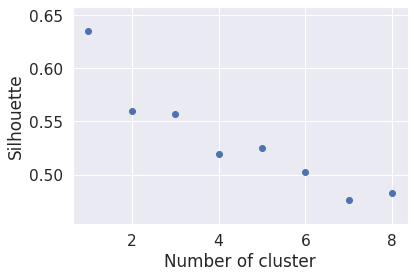

In [ ]:
plt.scatter(range(1, len(silhouette)+1), silhouette)
plt.xlabel('Number of cluster')
plt.ylabel('Silhouette')

plt.show()

Выберем K=5 и используем номер кластера как еще одну категориальную фичу

In [19]:
kmeans = KMeans(n_clusters=5, max_iter=1000, random_state=42, n_jobs=-1)
kmeans.fit(X_train[regression_ft])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [20]:
X_train_extended = X_train
X_train_extended['cluster'] = kmeans.predict(X_train[regression_ft])
X_train_extended = one_hot_encode(X_train_extended, 'cluster')

In [21]:
X_test_extended = X_test
X_test_extended['cluster'] = kmeans.predict(X_test[regression_ft])
X_test_extended = one_hot_encode(X_test_extended, 'cluster')

In [22]:
X_test_extended.columns

Index(['diff_plants_amount', 'check_sum', 'promo_amount', 'priv_lbl_amount',
       'alco_amount', 'food_amount', 'nonfood_amount', 'return_sum',
       'birthyear', 'days_since_last_purchase', 'purch_num', 'return_num',
       'most_freq_plant_type_HM', 'most_freq_plant_type_SM', 'gender_F',
       'gender_M', 'gender_nan', 'city_Moscow', 'city_Other',
       'city_St. Petersburg', 'cluster_0', 'cluster_1', 'cluster_3',
       'cluster_4'],
      dtype='object')

In [23]:
X_test_extended.insert(len(X_test_extended.columns)-2, 'cluster_2', 0)

DBSCAN

In [ ]:
k = 5
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=k, n_jobs=-1)
neigh.fit(X_train[regression_ft])
dist, ind = neigh.kneighbors(X_train[regression_ft])
distances = [d[-1] for d in dist]
distances.sort()

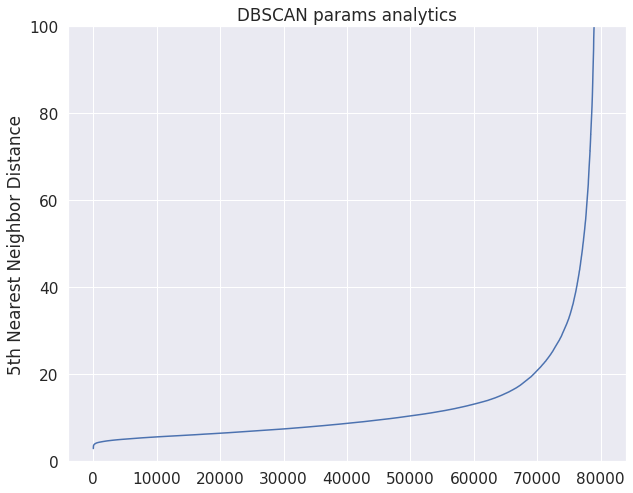

In [ ]:
plt.figure(figsize=(10,8))
plt.ylabel('{}th Nearest Neighbor Distance'.format(k))
plt.ylim((0, 100))
plt.title('DBSCAN params analytics')
plt.plot(range(len(distances)), distances)
plt.show()

возьмем eps=20

In [ ]:
db = DBSCAN(eps=20, min_samples=5, n_jobs=-1)
cluster_labels = db.fit_predict(X_train[regression_ft])

In [ ]:
np.unique(cluster_labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177])

Такое большое число кластеров, найденных DBSCAN'ом вряд ли можно проинтерпретировать

### Random Forest как baseline:

Без номеров кластеров:

In [22]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
print('roc-auc: {}'.format(roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])))

roc-auc: 0.8363496513598245


С номерами кластеров:

In [24]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_clf.fit(X_train_extended, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
print('roc-auc: {}'.format(roc_auc_score(y_test, rf_clf.predict_proba(X_test_extended)[:, 1])))

roc-auc: 0.8338547013559264


### Логистическая регрессия

In [61]:
# sklearn API friendly numeric features standart scaler:

class NumericScaler:
    def __init__(self, numeric_ft):
        self.numeric_ft = numeric_ft
        self.scaler = StandardScaler()
        
    def fit(self, X):
        self.scaler = self.scaler.fit(X[self.numeric_ft])
        pass
    
    def transform(self, X):
        X[self.numeric_ft] = self.scaler.transform(X[self.numeric_ft])
        return X
    
    def fit_transform(self, X, y=None):
        X[self.numeric_ft] = self.scaler.fit_transform(X[self.numeric_ft])
        return X

In [81]:
pipe = Pipeline([
    ('scaler', NumericScaler(regression_ft)),
    ('logit', LogisticRegression(random_state=42))
])

param_grid = {
    'logit__penalty' : ['l1', 'l2'],
    'logit__C' : np.logspace(-4, 2, num=20)
}

In [82]:
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    scoring='roc_auc',
    refit=True,
    verbose=1
)

Без номеров кластеров:

In [83]:
gcv = gcv.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   14.1s finished


In [84]:
gcv.best_estimator_['logit'].get_params()

{'C': 0.0008858667904100823,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [91]:
print('roc-auc: {}'.format(
    roc_auc_score(y_test, gcv.best_estimator_.predict_proba(X_test)[:, 1])))

roc-auc: 0.7835786670997256


С номерами кластеров:

In [92]:
gcv = gcv.fit(X_train_extended, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.1s finished


In [93]:
gcv.best_estimator_['logit'].get_params()

{'C': 0.0008858667904100823,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [95]:
print('roc-auc: {}'.format(
    roc_auc_score(y_test, gcv.best_estimator_.predict_proba(X_test_extended)[:, 1])))

roc-auc: 0.8270335270706017


### Градиентный бустинг

Без номеров кластеров:

In [26]:
# Подберем параметры кросс-валидацией
catbst_clf = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    eval_metric='AUC',
    metric_period=10,
    task_type='GPU'
)

param_grid = {
    'iterations' : [100, 500, 1000],
    'depth' : [4, 6, 7, 8, 9, 10],
    'l2_leaf_reg' : [1, 3, 5, 7, 9]
}

**Warning**: grid_search ~1 час в колабе на gpu

In [ ]:
catbst_clf.grid_search(
    param_grid, 
    X_train, 
    y_train,
    cv=3    
)

In [22]:
best_params = catbst_clf.get_params()
print('best params:', best_params)

best params: {'task_type': 'GPU', 'eval_metric': 'AUC', 'metric_period': 10, 'random_seed': 42, 'loss_function': 'Logloss', 'depth': 8, 'l2_leaf_reg': 7, 'iterations': 500}


fit с лучшими параметрами:

In [27]:
best_params = {
    'eval_metric': 'AUC',
    'metric_period': 10,
    'random_seed': 42,
    'loss_function': 'Logloss',
    'depth': 8,
    'l2_leaf_reg': 7,
    'iterations': 500
}

In [28]:
catbst_clf = CatBoostClassifier(
    **best_params
)

In [29]:
catbst_clf.fit(X_train, y_train,
               eval_set=(X_test, y_test),
               use_best_model=True)

0:	test: 0.8211467	best: 0.8211467 (0)	total: 87.6ms	remaining: 43.7s
10:	test: 0.8403916	best: 0.8403916 (10)	total: 244ms	remaining: 10.8s
20:	test: 0.8414616	best: 0.8414616 (20)	total: 434ms	remaining: 9.9s
30:	test: 0.8420864	best: 0.8420864 (30)	total: 612ms	remaining: 9.27s
40:	test: 0.8428250	best: 0.8428250 (40)	total: 813ms	remaining: 9.1s
50:	test: 0.8434360	best: 0.8434360 (50)	total: 986ms	remaining: 8.68s
60:	test: 0.8439136	best: 0.8439136 (60)	total: 1.23s	remaining: 8.88s
70:	test: 0.8443405	best: 0.8443405 (70)	total: 1.4s	remaining: 8.43s
80:	test: 0.8447445	best: 0.8447445 (80)	total: 1.59s	remaining: 8.24s
90:	test: 0.8449479	best: 0.8449479 (90)	total: 1.78s	remaining: 8s
100:	test: 0.8450530	best: 0.8450530 (100)	total: 1.98s	remaining: 7.8s
110:	test: 0.8451856	best: 0.8451856 (110)	total: 2.15s	remaining: 7.55s
120:	test: 0.8453642	best: 0.8453642 (120)	total: 2.35s	remaining: 7.35s
130:	test: 0.8455315	best: 0.8455315 (130)	total: 2.52s	remaining: 7.09s
140:	t

In [30]:
print('roc-auc: {}'.format(roc_auc_score(y_test, catbst_clf.predict_proba(X_test)[:, 1])))

roc-auc: 0.8461033073266084


С номерами кластеров:

In [31]:
catbst_clf = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    eval_metric='AUC',
    metric_period=10,
    task_type='GPU'
)

param_grid = {
    'iterations' : [100, 500, 1000],
    'depth' : [4, 6, 7, 8, 9, 10],
    'l2_leaf_reg' : [1, 3, 5]
}

In [28]:
catbst_clf.grid_search(
    param_grid,
    X_train_extended, 
    y_train, 
    cv=3
)

bestTest = 0.8389597535
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8389598	best: 0.8389598 (0)	total: 2.5s	remaining: 2m 12s
bestTest = 0.8390485644
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8390486	best: 0.8390486 (1)	total: 5.46s	remaining: 2m 21s
bestTest = 0.8390273452
bestIteration = 99
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8390273	best: 0.8390486 (1)	total: 8.48s	remaining: 2m 24s
bestTest = 0.8414334655
bestIteration = 499
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8414335	best: 0.8414335 (3)	total: 20.9s	remaining: 4m 21s
bestTest = 0

{'cv_results': defaultdict(list,
             {'iterations': [0,
               10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               210,
               220,
               230,
               240,
               250,
               260,
               270,
               280,
               290,
               300,
               310,
               320,
               330,
               340,
               350,
               360,
               370,
               380,
               390,
               400,
               410,
               420,
               430,
               440,
               450,
               460,
               470,
    

In [29]:
best_params = catbst_clf.get_params()
print('best params:', best_params)

best params: {'task_type': 'GPU', 'eval_metric': 'AUC', 'metric_period': 10, 'random_seed': 42, 'loss_function': 'Logloss', 'depth': 8, 'l2_leaf_reg': 3, 'iterations': 1000}


fit с лучшими параметрами

In [24]:
best_params = {
    'eval_metric': 'AUC',
    'metric_period': 10,
    'random_seed': 42,
    'loss_function': 'Logloss',
    'depth': 8,
    'l2_leaf_reg': 3,
    'iterations': 1000
}

In [25]:
catbst_clf = CatBoostClassifier(
    **best_params
)

In [26]:
catbst_clf.fit(X_train_extended, y_train,
               eval_set=(X_test_extended, y_test),
               use_best_model=True)

0:	test: 0.8244207	best: 0.8244207 (0)	total: 91.1ms	remaining: 1m 30s
10:	test: 0.8385908	best: 0.8385908 (10)	total: 241ms	remaining: 21.7s
20:	test: 0.8401233	best: 0.8401233 (20)	total: 427ms	remaining: 19.9s
30:	test: 0.8408829	best: 0.8408829 (30)	total: 589ms	remaining: 18.4s
40:	test: 0.8419022	best: 0.8419022 (40)	total: 773ms	remaining: 18.1s
50:	test: 0.8426702	best: 0.8426702 (50)	total: 937ms	remaining: 17.4s
60:	test: 0.8432318	best: 0.8432318 (60)	total: 1.13s	remaining: 17.4s
70:	test: 0.8438251	best: 0.8438251 (70)	total: 1.31s	remaining: 17.2s
80:	test: 0.8442591	best: 0.8442591 (80)	total: 1.53s	remaining: 17.4s
90:	test: 0.8445096	best: 0.8445096 (90)	total: 1.7s	remaining: 17s
100:	test: 0.8447186	best: 0.8447186 (100)	total: 1.9s	remaining: 16.9s
110:	test: 0.8450200	best: 0.8450200 (110)	total: 2.07s	remaining: 16.6s
120:	test: 0.8452099	best: 0.8452099 (120)	total: 2.26s	remaining: 16.4s
130:	test: 0.8452768	best: 0.8452768 (130)	total: 2.42s	remaining: 16.1s
14

In [27]:
print('roc-auc: {}'.format(roc_auc_score(y_test, catbst_clf.predict_proba(X_test_extended)[:, 1])))

roc-auc: 0.8459423374663797


### Для оценки важности признаков используем shap-values

In [28]:
shap.initjs()

In [31]:
explainer = shap.TreeExplainer(catbst_clf)

In [32]:
shap_values = explainer.shap_values(X_train_extended, y_train)

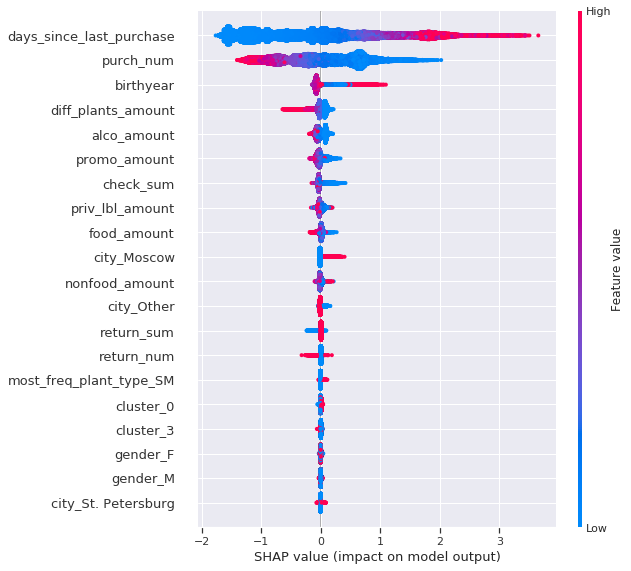

In [33]:
shap.summary_plot(shap_values, X_train_extended)

### Проинтерпретируем график:

По горизонатли отложены shap value: вклад фичи в значение ответа. В нашем случае: чем больше shap value -- тем больше вероятность что клиент уйдет

Цветом обозначены значения признаков

Итак, 

вероятность оттока увеличивают следующие фичи и их значения:

- Большое количество дней с последней транзакции
- Малое число покупок в среднем в месяц
- Небольшой возраст клиента
- Маленький средний чек
- Малое число уникальных магазинов, в которых побывал клиент
- Малое число алкоголя и еды в среднем в чеке
- Малое число товаров по акции в среднем в чеке
- клиент живет в Москве (интересный результат, можно предположить что это связано с большой плотностью магазинов разных ритейлеров, поэтому москвичи менее лояльны)

вероятность оттока уменьшают фичи и их значения:

- Малое число дней с момента последней транзакции
- Большое число покупок в среднем в месяц
- Большое число уникальных магазинов
- Большое число возвратов             ?
- Большой средний чек возврата        ?